# Projeto de análise de dados do Titanic
O objetivo deste projeto é analisar os dados do Titanic e tentar responder algumas perguntas sobre o naufrágio do navio. Para isso, utilizaremos a biblioteca Pandas para manipulação dos dados e a biblioteca Matplotlib para visualização dos dados. Para modelagem dos dados, utilizaremos a biblioteca Scikit-Learn.

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def preparedata(df):
    from sklearn.preprocessing import MinMaxScaler
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    title_age_mean = df.groupby('Title')['Age'].mean()
    title_age_mean = title_age_mean.to_dict()
    df['Age'] = df.apply(lambda x: title_age_mean[x['Title']] if pd.isnull(x['Age']) else x['Age'], axis=1)
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Sex'] = (df['Sex']=='female').astype(int)
    df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'Title'], axis=1, inplace=True)
    q3 = df['Fare'].quantile(0.75)
    df.loc[df['Fare'] > q3, 'Fare'] = q3
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    scaler = MinMaxScaler()
    df[['Age', 'Fare']] = scaler.fit_transform(df[['Age', 'Fare']])
    return df

In [17]:
def grafbarscores(*scores):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import warnings
    warnings.filterwarnings('ignore')
    df_scores = pd.DataFrame(columns=['Model', 'Score'])
    for score in scores:
        df_scores.loc[len(df_scores)] = [score[0], score[1]]
    fig, ax = plt.subplots()
    sns.barplot(x='Score', y='Model', data=df_scores.sort_values(by='Score', ascending=False), ax=ax)
    ax.set_xlim([0, 1])
    for p in ax.patches:
        ax.annotate("%.4f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()+0.65), xytext=(5, 10), textcoords='offset points')
    plt.xlabel('Score (accuracy)')
    plt.ylabel('Model')
    plt.title('Machine Learning Model Scores')
    plt.show()

In [ ]:
# Criando os Grids de parâmetros para cada modelo
grid_dt = {'criterion': ['gini', 'entropy'],
           'splitter': ['best', 'random'],
           'max_depth': [2*n for n in range(1,10)],
           'max_features': ['auto', 'sqrt'],
           'min_samples_leaf': [1, 2, 4],
           'min_samples_split': [2, 5, 10]}
grid_rf = {'n_estimators': [100, 200, 300, 400, 500],
              'criterion': ['gini', 'entropy'],
                'max_depth': [2*n for n in range(1,10)],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [1, 2, 4],
                'min_samples_split': [2, 5, 10]}
grid_lr = {'penalty': ['l1', 'l2'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100],  
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid_knn = {'n_neighbors': [2*n for n in range(1,10)],
                'weights': ['uniform', 'distance'], 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_svm = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'gamma': ['scale', 'auto']}
# Criando os modelos
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
lr = LogisticRegression()
knn = KNeighborsClassifier()
svm = SVC()
# Criando os GridSearchCV
gridcv_dt = GridSearchCV(dt, grid_dt, cv=5, scoring='accuracy')
gridcv_lr = GridSearchCV(lr, grid_lr, cv=5, scoring='accuracy')
gridcv_knn = GridSearchCV(knn, grid_knn, cv=5, scoring='accuracy')
gridcv_svm = GridSearchCV(svm, grid_svm, cv=5, scoring='accuracy')



In [ ]:
df_train = preparedata(pd.read_csv('./data/raw/train.csv'))
df_train.to_csv('./data/processed/second_train.csv', index=False)
df_test_pred = preparedata(pd.read_csv('./data/raw/test.csv'))
df_test = pd.read_csv('./data/raw/test.csv')
df_test_pred.to_csv('./data/processed/second_test.csv', index=False)

In [ ]:
# vamos aplicar o modelo de machine learning: Decision Tree, Random Forest, Logistic Regression, KNN, SVM, Naive Bayes sem separar os dados em treino e teste
models = []
models.append(('Decision Tree', gridcv_dt))
models.append(('Logistic Regression', gridcv_lr))
models.append(('KNN', gridcv_knn))
models.append(('SVM', gridcv_svm))

results = []
names = []
desc = 'Machine Learning Model Scores'
# criar um for usando tqdm para mostrar o progresso
for name, model in tqdm(models, desc=desc):
    model.fit(df_train.drop('Survived', axis=1), df_train['Survived'])
    result = model.score(df_train.drop('Survived', axis=1), df_train['Survived'])
    results.append(result)
    names.append(name)
    df_test['Survived'] = model.predict(df_test_pred)
    df_test[['PassengerId', 'Survived']].to_csv('./data/submission/second_' + name + '.csv', index=False)


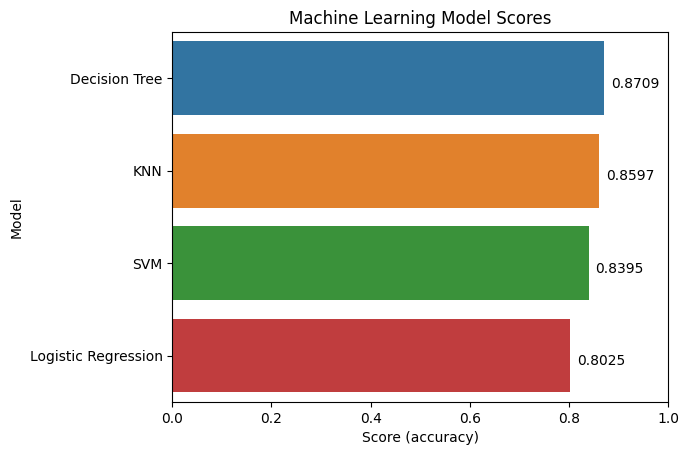

In [18]:
grafbarscores(*zip(names, results))

In [20]:
# vamos gerar os arquivos de submissão para o melhor modelo de Decision Tree
df_test['Survived'] = gridcv_dt.predict(df_test_pred)
df_test[['PassengerId', 'Survived']].to_csv('./data/submission/second_best_model.csv', index=False)

In [21]:
# vamos gerar os arquivos de submissão para todos os modelos
for name, model in tqdm(models, desc=desc):
    df_test['Survived'] = model.predict(df_test_pred)
    df_test[['PassengerId', 'Survived']].to_csv('./data/submission/second_' + name + '.csv', index=False)


Machine Learning Model Scores: 100%|██████████| 4/4 [00:00<00:00, 141.40it/s]
